# Commands to Prepare Files in Google Colab 

In [4]:
%cd /content

/content


In [5]:
!gdown https://drive.google.com/uc?id=1A4yorwNwSVQimtpGs4bZ7lfNXV_KGEpi

Downloading...
From: https://drive.google.com/uc?id=1A4yorwNwSVQimtpGs4bZ7lfNXV_KGEpi
To: /content/data.zip
100% 802M/802M [00:11<00:00, 69.9MB/s]


In [6]:
!ls

data.zip  sample_data


In [ ]:
!unzip data.zip

# Preprocessing

End result: batches of RGB image data containing training, validation, and test data with labels incorporated. (It is very difficult to combine these into X and y matrices, but the batch format is perfectly compatible with TensorFlow's models.)

In [8]:
from tensorflow import keras 
import tensorflow as tf
import numpy as np

In [9]:
path = "data/fruits-360_dataset/fruits-360/Training"

train_ds = keras.utils.image_dataset_from_directory(
    path, image_size = (100, 100), seed = 123, batch_size = 128, validation_split=0.2, subset="training", label_mode="categorical"
)

Found 67692 files belonging to 131 classes.
Using 54154 files for training.


In [10]:
path = "data/fruits-360_dataset/fruits-360/Training"

val_ds = keras.utils.image_dataset_from_directory(
    path, image_size = (100, 100), seed = 123, batch_size = 128, validation_split=0.2, subset="validation", label_mode="categorical"
)

Found 67692 files belonging to 131 classes.
Using 13538 files for validation.


In [11]:
path = "data/fruits-360_dataset/fruits-360/Test"

test_ds = keras.utils.image_dataset_from_directory(
    path, image_size=(100, 100), seed=123, batch_size=128, label_mode="categorical"
)

Found 22688 files belonging to 131 classes.


In [ ]:
class_names = train_ds.class_names
class_names

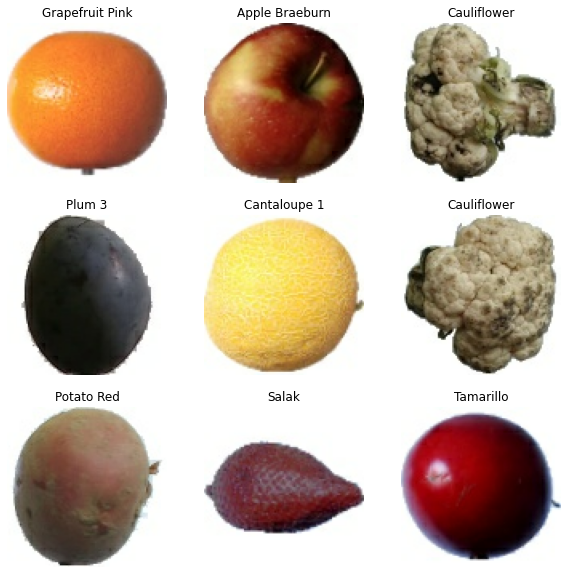

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i].numpy())])
    plt.axis("off")

# Our Convolutional Neural Network



In [14]:
import tensorflow_datasets as tfds

In [15]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [16]:
model.compile(
  optimizer='adam',
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', 
                   patience=5, verbose=1,
                   restore_best_weights=True)

In [ ]:
model.fit(
  train_ds,
  callbacks=[es],
  validation_data=val_ds,
  epochs=50
)

## Visualizing Model Architecture

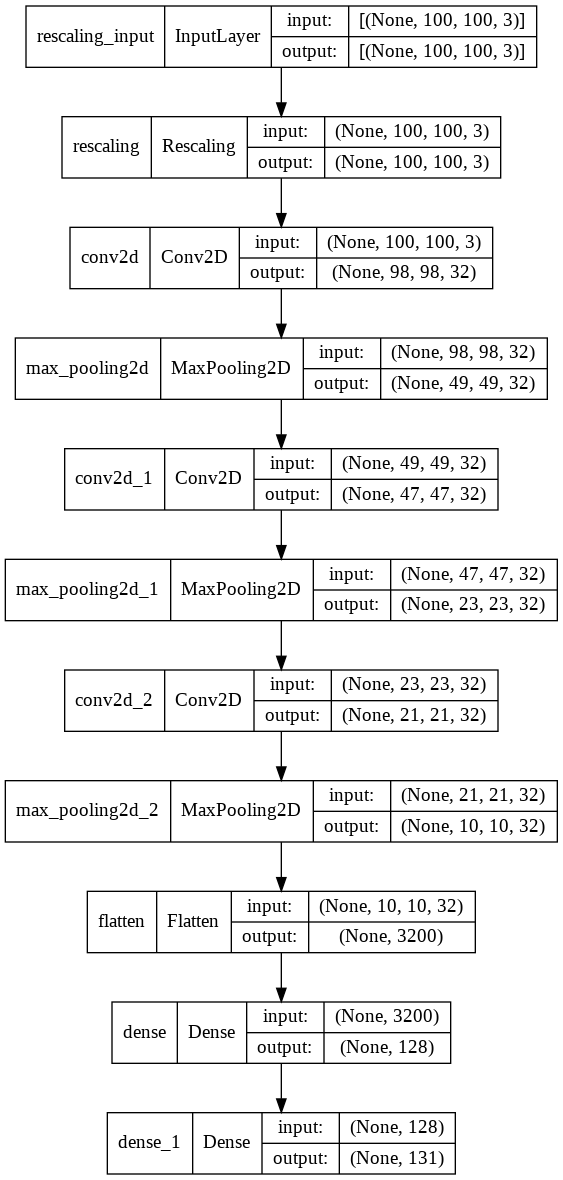

In [159]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

## Evaluating Our Model

In [22]:
# # Use this if loading in model from GitHub repository (saved_model folder)
# !gdown https://drive.google.com/uc?id=1gYsQyOMmg2q_ypvePZVwEL70I400diEv
# !unzip saved_model.zip

# loaded_model = tf.keras.models.load_model("/content/saved_model")
# model = loaded_model

In [81]:
model.evaluate(test_ds)

178/178 [==============================] - 12s 65ms/step - loss: 0.3507 - accuracy: 0.9662


[0.3506889045238495, 0.9661935567855835]

In [111]:
y_pred = []
y_true = []

for image_batch, label_batch in test_ds: 
   y_true.append(label_batch)
   preds = model.predict(image_batch)
   y_pred.append(np.argmax(preds, axis = - 1))

correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [121]:
true_labels = np.argmax(correct_labels, axis=1)
pred_labels = np.array(predicted_labels)

### Confusion Matrix

In [130]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(true_labels, pred_labels)

Text(0.5, 1.0, 'Confusion Matrix')

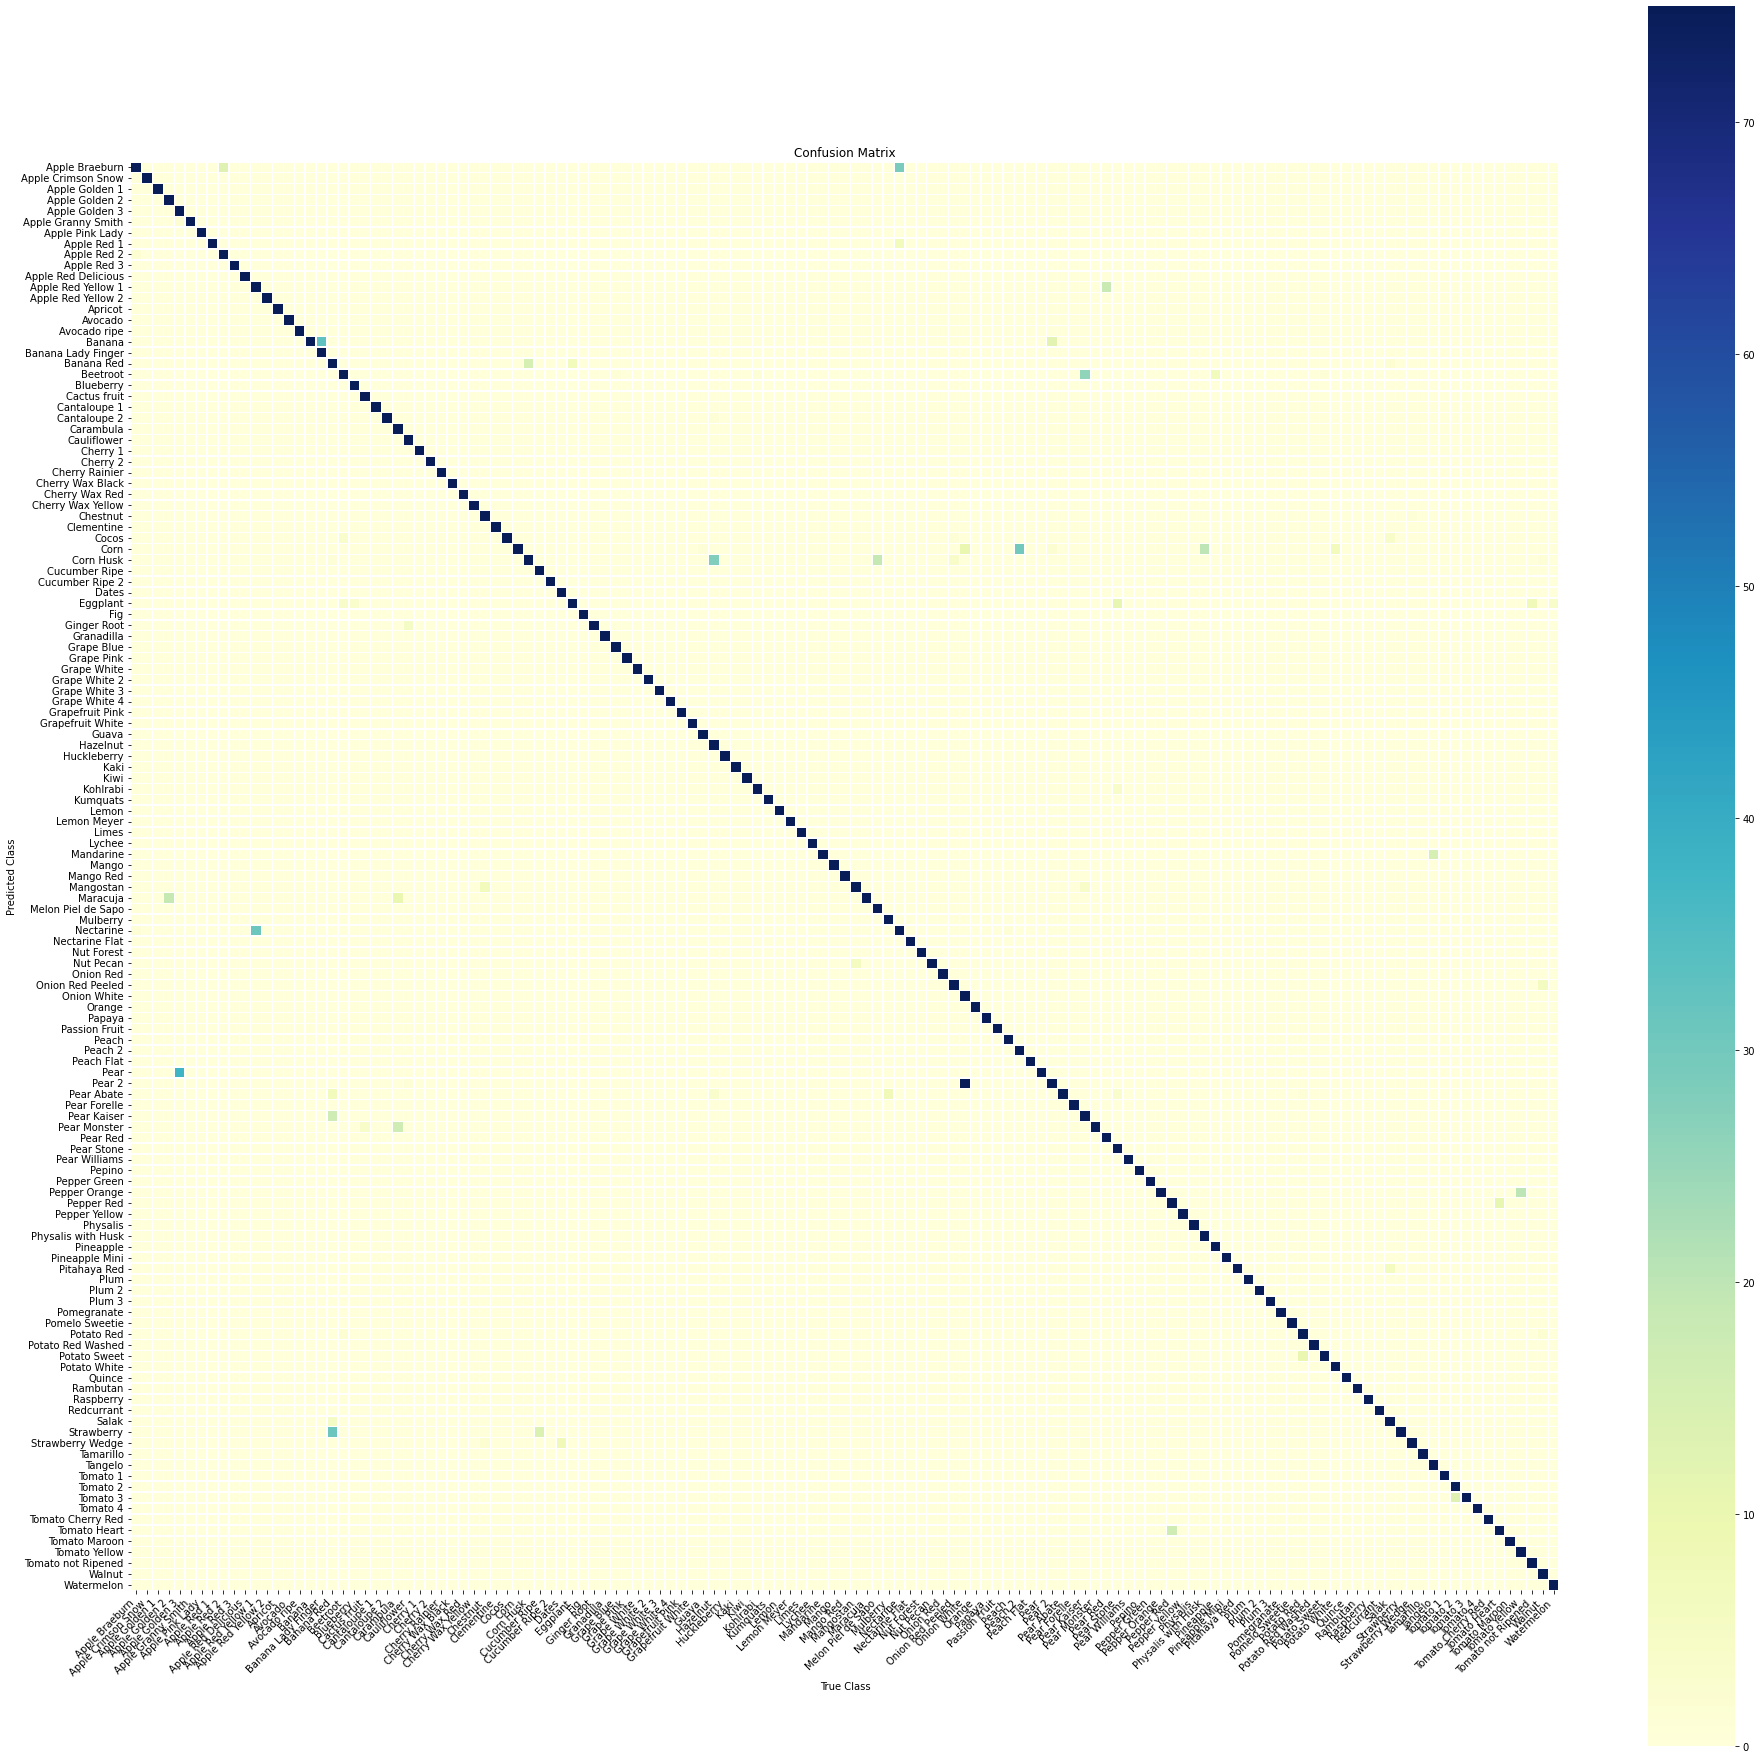

In [135]:
import seaborn as sns

import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 600

f,ax=plt.subplots(figsize=((32,32)))

hmap = sns.heatmap(conf, annot=False, linewidth=.5,fmt='.2f',ax=ax, square=True, cmap='YlGnBu', vmax=75)
hmap.set_xticklabels(hmap.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

ax.set_xlabel("True Class")
ax.set_ylabel("Predicted Class")
ax.set_title("Confusion Matrix")

### Performance Metrics

In [158]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Accuracy : " + str(accuracy_score(true_labels, pred_labels)))
print("Precision : " + str(precision_score(true_labels, pred_labels, average='macro')))
print("Recall : " + str(recall_score(true_labels, pred_labels, average='macro')))
print("F1 : " + str(f1_score(true_labels, pred_labels, average='macro')))

Accuracy : 0.7068494358251057
Precision : 0.7439603563981614
Recall : 0.7001071139696347
F1 : 0.6973643084985377


# Transfer Learning with ImageNet's Inception v3 Model

In [136]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model # Sequential 
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import backend as K

In [139]:
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_initializer="he_normal")(x)
predictions = Dense(num_classes, activation='softmax')(x)
transfer_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
  layer.trainable = False 

transfer_model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

In [140]:
transfer_model.fit(
    train_ds, callbacks=[es],
    validation_data = val_ds, 
    epochs=50)

Epoch 1/50
424/424 [==============================] - 70s 154ms/step - loss: 8.7415 - accuracy: 0.5921 - val_loss: 0.9096 - val_accuracy: 0.7590
Epoch 2/50
424/424 [==============================] - 351s 827ms/step - loss: 0.5246 - accuracy: 0.8541 - val_loss: 0.4369 - val_accuracy: 0.8805
Epoch 3/50
424/424 [==============================] - 66s 156ms/step - loss: 0.3529 - accuracy: 0.8966 - val_loss: 0.3618 - val_accuracy: 0.8919
Epoch 4/50
424/424 [==============================] - 66s 156ms/step - loss: 0.2585 - accuracy: 0.9247 - val_loss: 0.5294 - val_accuracy: 0.8716
Epoch 5/50
424/424 [==============================] - 66s 155ms/step - loss: 0.2895 - accuracy: 0.9156 - val_loss: 0.4330 - val_accuracy: 0.8843
Epoch 6/50
424/424 [==============================] - 67s 156ms/step - loss: 0.2786 - accuracy: 0.9226 - val_loss: 0.3463 - val_accuracy: 0.9020
Epoch 7/50
424/424 [==============================] - 66s 156ms/step - loss: 0.2246 - accuracy: 0.9359 - val_loss: 0.4717 - val_a

## Evaluating Model Trained on Top of Inception v3 (Transfer Learning)

In [144]:
transfer_model.evaluate(test_ds)

178/178 [==============================] - 24s 132ms/step - loss: 2.6631 - accuracy: 0.7068


[2.6630656719207764, 0.7068494558334351]

In [146]:
y_pred = []
y_true = []

for image_batch, label_batch in test_ds: 
   y_true.append(label_batch)
   preds = transfer_model.predict(image_batch)
   y_pred.append(np.argmax(preds, axis = - 1))

correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [147]:
true_labels = np.argmax(correct_labels, axis=1)
pred_labels = np.array(predicted_labels)

### Confusion Matrix

In [148]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(true_labels, pred_labels)

Text(0.5, 1.0, 'Confusion Matrix')

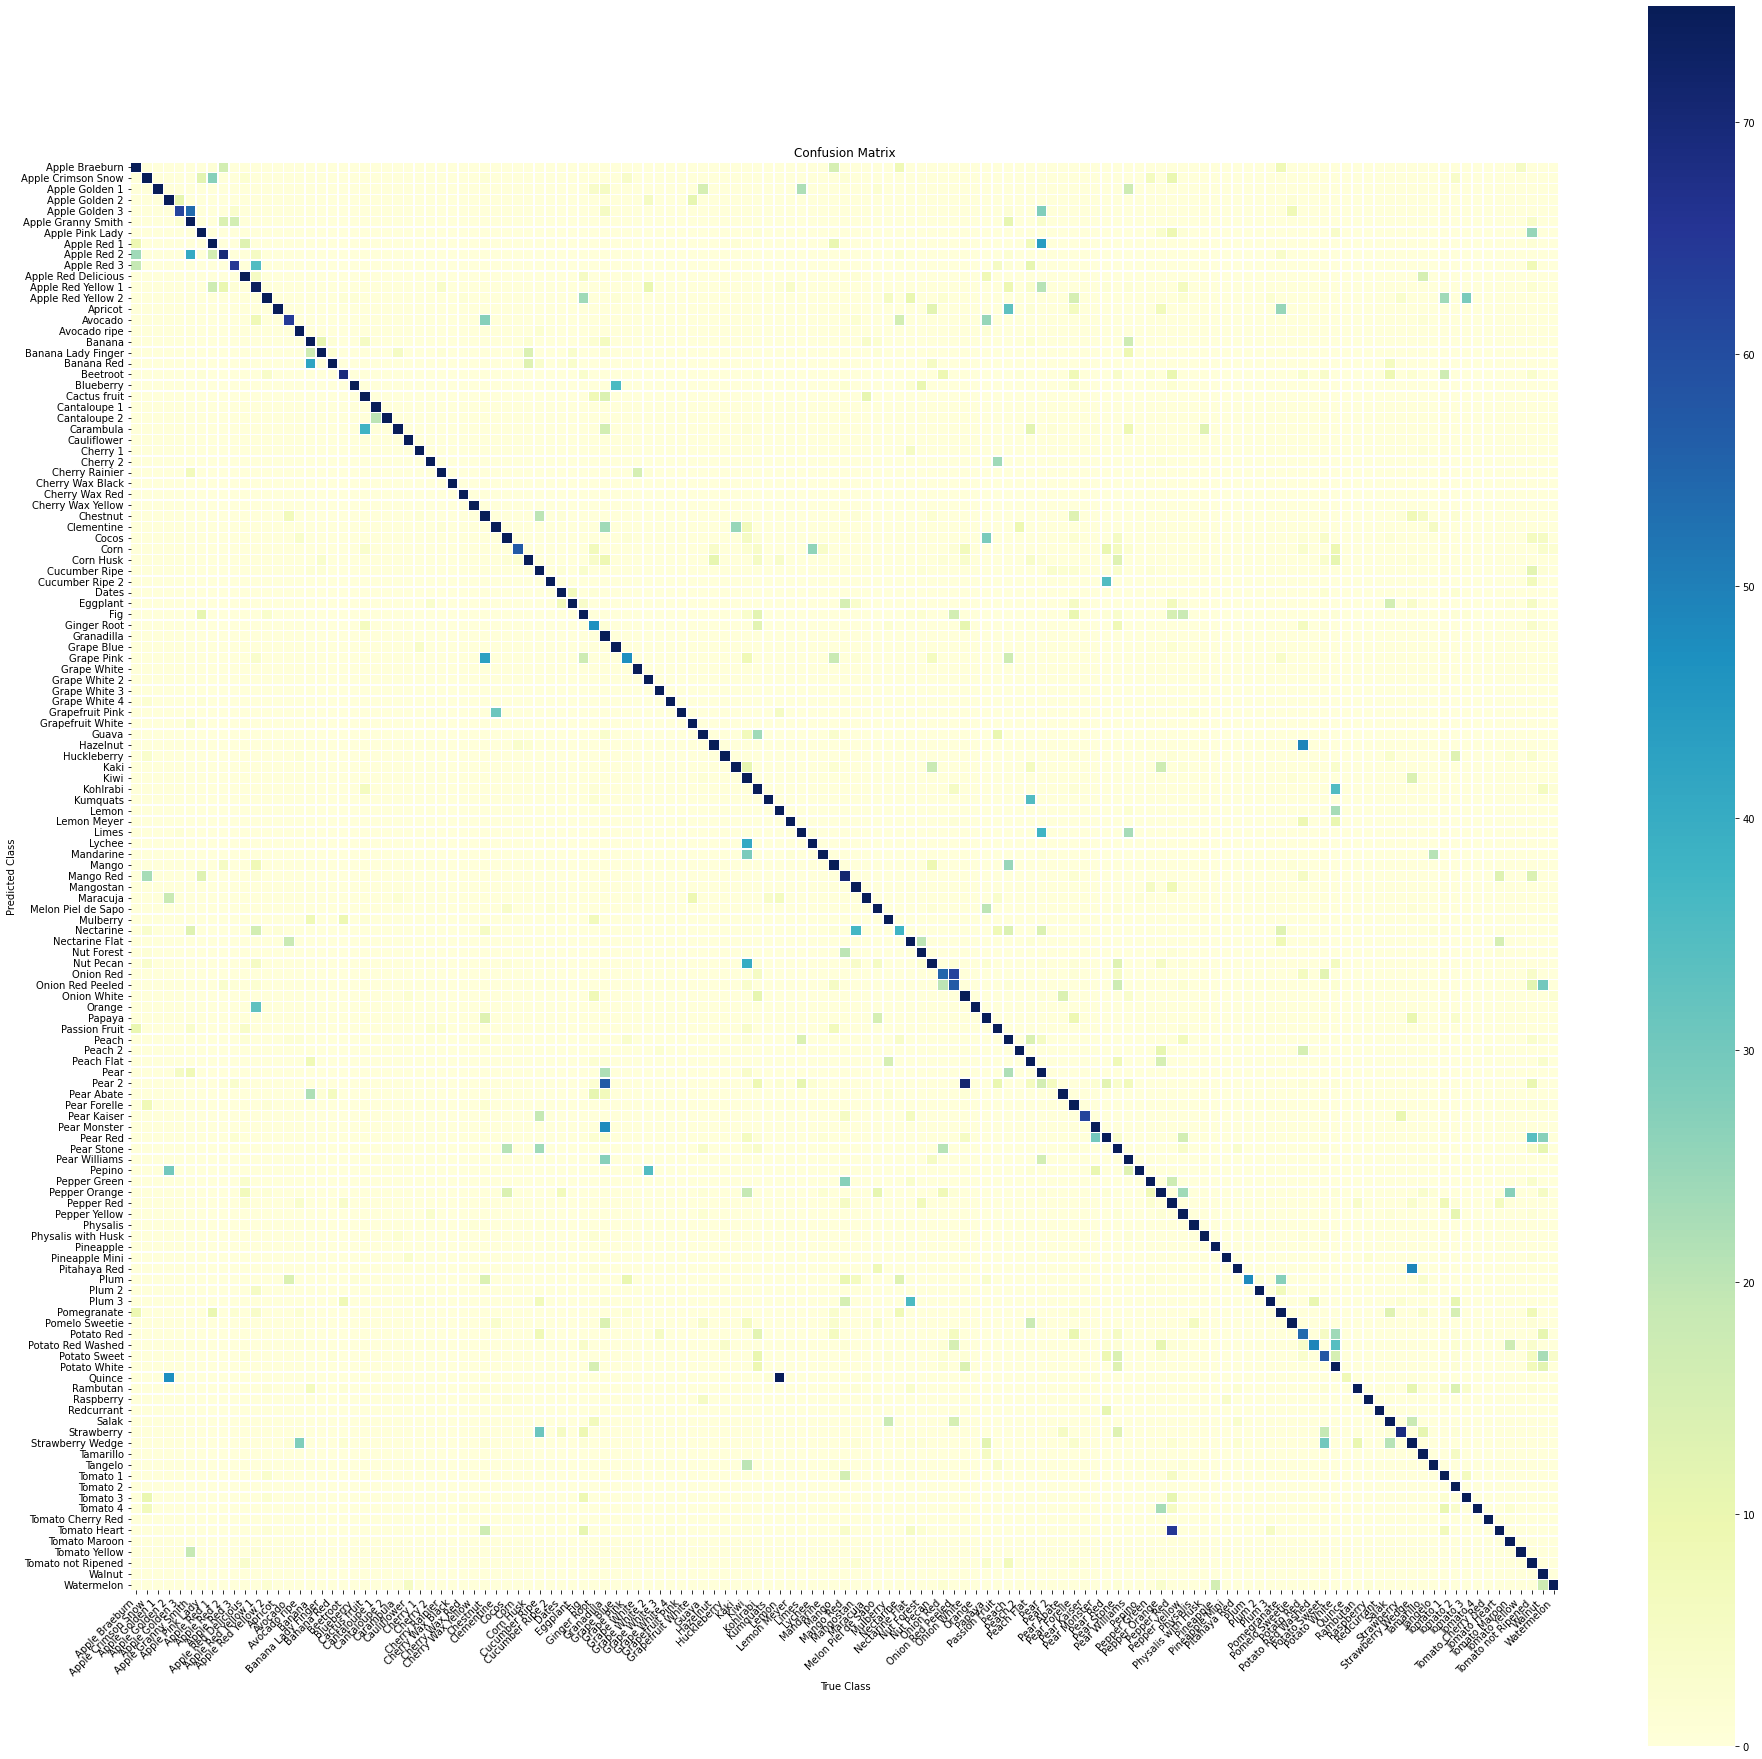

In [152]:
import seaborn as sns

import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 600

f,ax=plt.subplots(figsize=((32,32)))

hmap = sns.heatmap(conf, annot=False, linewidth=.5,fmt='.2f',ax=ax, square=True, cmap='YlGnBu', vmax=75)
hmap.set_xticklabels(hmap.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

ax.set_xlabel("True Class")
ax.set_ylabel("Predicted Class")
ax.set_title("Confusion Matrix")

### Performance Metrics

In [154]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Accuracy : " + str(accuracy_score(true_labels, pred_labels)))
print("Precision : " + str(precision_score(true_labels, pred_labels, average='macro')))
print("Recall : " + str(recall_score(true_labels, pred_labels, average='macro')))
print("F1 : " + str(f1_score(true_labels, pred_labels, average='macro')))

Accuracy : 0.7068494358251057
Precision : 0.7439603563981614
Recall : 0.7001071139696347
F1 : 0.6973643084985377


# Testing Trained Models on Hand-Picked Images

Prediction for Image Below: Watermelon


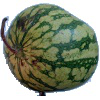

In [46]:
import PIL
image_path = "/content/data/fruits-360_dataset/fruits-360/Test/Watermelon/r_113_100.jpg"

image = PIL.Image.open(image_path)
image_resized = image.resize((100, 100))
image_array = np.array(image_resized).reshape(1, 100, 100, 3)

print("Prediction for Image Below:", class_names[np.argmax(model.predict(image_array))])
image_resized